# Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split, cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from mlxtend.classifier import StackingClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Train data

In [2]:
train = pd.read_csv("C:/Saurabh/My phone/datasets/Credit Card Lead Prediction/train_s3TEQDk.csv")
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [3]:
train.describe(include = 'all')

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
count,245725,245725,245725.000000,245725,245725,245725,245725.000000,216400,2.457250e+05,245725,245725.000000
unique,245725,2,NaN,35,4,4,NaN,2,NaN,2,NaN
top,DKA6JWPW,Male,NaN,RG268,Self_Employed,X1,NaN,No,NaN,No,NaN
freq,1,134197,NaN,35934,100886,103718,NaN,144357,NaN,150290,NaN
mean,NaN,NaN,43.856307,NaN,NaN,NaN,46.959141,NaN,1.128403e+06,NaN,0.237208
std,NaN,NaN,14.828672,NaN,NaN,NaN,32.353136,NaN,8.529364e+05,NaN,0.425372
min,NaN,NaN,23.000000,NaN,NaN,NaN,7.000000,NaN,2.079000e+04,NaN,0.000000
25%,NaN,NaN,30.000000,NaN,NaN,NaN,20.000000,NaN,6.043100e+05,NaN,0.000000
50%,NaN,NaN,43.000000,NaN,NaN,NaN,32.000000,NaN,8.946010e+05,NaN,0.000000
75%,NaN,NaN,54.000000,NaN,NaN,NaN,73.000000,NaN,1.366666e+06,NaN,0.000000


In [4]:
data=train.drop('ID', axis=1)

In [5]:
data.isnull().sum()

Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

# Test data

In [6]:
test = pd.read_csv('C:/Saurabh/My phone/datasets/Credit Card Lead Prediction/test_mSzZ8RL.csv')
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [7]:
test.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
dtype: int64

# Preprocessing

### Avg_Account_Balance

<AxesSubplot:xlabel='Avg_Account_Balance'>

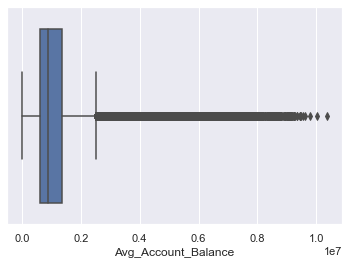

In [8]:
sns.boxplot(data['Avg_Account_Balance'])

In [9]:
q = data['Avg_Account_Balance'].quantile(0.95)
df = data[data['Avg_Account_Balance']<q]

<AxesSubplot:xlabel='Avg_Account_Balance'>

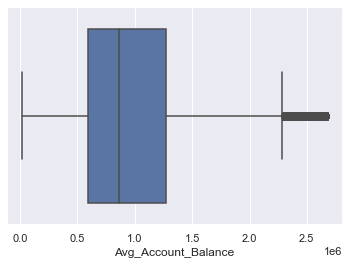

In [10]:
sns.boxplot(df['Avg_Account_Balance'])

Now that we have removed some outliers we can proceed with the feature engineering.

In [11]:
df['Avg_Account_Balance'] = np.sqrt(df['Avg_Account_Balance'])

### Credit_Product

In [12]:
df.Credit_Product.value_counts()

No     137706
Yes     68096
Name: Credit_Product, dtype: int64

In [13]:
df.Credit_Product.unique()

array(['No', nan, 'Yes'], dtype=object)

###### Filling null vallues with 'None'.

In [14]:
df['Credit_Product'] = df['Credit_Product'].fillna('None')

# Mapping

In [15]:
train_df = df.copy()
test_df=test.copy()

In [16]:
train_df.dtypes

Gender                  object
Age                      int64
Region_Code             object
Occupation              object
Channel_Code            object
Vintage                  int64
Credit_Product          object
Avg_Account_Balance    float64
Is_Active               object
Is_Lead                  int64
dtype: object

###### Making list with names of columns which have categorical data which we are going to use further.

In [17]:
catg_col = ['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']

In [18]:
comb = [train_df,test_df]

### Gender

In [19]:
for a in comb:
    a['Gender'] = a['Gender'].map({'Male':1,'Female':0})
    a['Gender'] = a['Gender'].astype(int)

### Region_Code

In [20]:
from sklearn.preprocessing import LabelEncoder

In [21]:
for a in comb:
    le = LabelEncoder()
    a['Region_Code'] = le.fit_transform(a['Region_Code'])

### Occupation

In [22]:
for a in comb:
    a['Occupation'] = a['Occupation'].map({'Other':0,'Salaried':1,'Self_Employed':2,'Entrepreneur':3})
    a['Occupation'] = a['Occupation'].astype(int)

### Channel_Code

In [23]:
for a in comb:
    a['Channel_Code'] = a['Channel_Code'].map({'X1':0,'X2':1,'X3':2,'X4':3})
    a['Channel_Code'] = a['Channel_Code'].astype(int)

### Credit_Product

In [24]:
for a in comb:
    a['Credit_Product'] = a['Credit_Product'].map({'Yes':1,'No':0})
    a['Credit_Product'] = a['Credit_Product'].fillna(3)
    a['Credit_Product'] = a['Credit_Product'].astype(int)

### Is_Active

In [25]:
for a in comb:
    a['Is_Active'] = a['Is_Active'].map({'Yes':1,'No':0})
    a['Is_Active'] = a['Is_Active'].astype(int)

# Input and output

In [26]:
x=train_df.drop(['Is_Lead'], axis=1)
y=train_df['Is_Lead']

## train-test split

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Classifiers

### Logistic 

In [28]:
log = LogisticRegression()
log.fit(x_train,y_train)

LogisticRegression()

In [29]:
score_log=log.score(x_test,y_test)
score_log

0.846534441398218

In [30]:
y_log_pred_proba = log.predict_proba(x_test)[:,1]
auc_log = roc_auc_score(y_test, y_log_pred_proba)
print('ROC AUC score: '+str(auc_log))

ROC AUC score: 0.829993688517233


In [31]:
f1_score(y_test, log.predict(x_test))

0.589374749269299

### Decision tree

In [32]:
dec = DecisionTreeClassifier(max_depth=8)
dec.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=8)

In [33]:
score_dec=dec.score(x_test,y_test)
score_dec

0.857029643591501

In [34]:
y_dec_pred_proba = dec.predict_proba(x_test)[:,1]
auc_dec = roc_auc_score(y_test, y_dec_pred_proba)
print('ROC AUC score: '+str(auc_dec))

ROC AUC score: 0.8683625999258742


In [35]:
f1_score(y_test, dec.predict(x_test))

0.6188110330649306

### Random forest

In [36]:
rnd = RandomForestClassifier(max_depth=8)
rnd.fit(x_train,y_train)

RandomForestClassifier(max_depth=8)

In [37]:
score_rnd=rnd.score(x_test,y_test)
score_rnd

0.8569439684715559

In [38]:
y_rnd_pred_proba = rnd.predict_proba(x_test)[:,1]
auc_rnd = roc_auc_score(y_test, y_rnd_pred_proba)
print('ROC AUC score: '+str(auc_rnd))

ROC AUC score: 0.8695286341552373


In [39]:
f1_score(y_test, rnd.predict(x_test))

0.6139975726752587

### Ada Boost

In [40]:
ada = AdaBoostClassifier()
ada.fit(x_train,y_train)

AdaBoostClassifier()

In [41]:
score_ada=ada.score(x_test,y_test)
score_ada

0.8561728923920493

In [42]:
y_ada_pred_proba = ada.predict_proba(x_test)[:,1]
auc_ada = roc_auc_score(y_test, y_ada_pred_proba)
print('ROC AUC score: '+str(auc_ada))

ROC AUC score: 0.8652708053012386


In [43]:
f1_score(y_test, ada.predict(x_test))

0.6208570944610694

### Gradient Boost

In [44]:
grd = GradientBoostingClassifier()
grd.fit(x_train,y_train)

GradientBoostingClassifier()

In [45]:
score_grd=grd.score(x_test,y_test)
score_grd

0.8600496915695682

In [46]:
y_grd_pred_proba = grd.predict_proba(x_test)[:,1]
auc_grd = roc_auc_score(y_test, y_grd_pred_proba)
print('ROC AUC score: '+str(auc_grd))

ROC AUC score: 0.8716802804020218


In [47]:
f1_score(y_test, grd.predict(x_test))

0.642911793638649

### XG Boost

In [48]:
xgb = XGBClassifier()
xgb.fit(x_train,y_train)

[23:41:08] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
score_xgb=xgb.score(x_test,y_test)
score_xgb

0.8603709732693626

In [50]:
y_xgb_pred_proba = xgb.predict_proba(x_test)[:,1]
auc_xgb = roc_auc_score(y_test, y_xgb_pred_proba)
print('ROC AUC score: '+str(auc_xgb))

ROC AUC score: 0.87079875900292


In [51]:
f1_score(y_test, xgb.predict(x_test))

0.6504370207517829

### Cat Boost

In [52]:
params = {'eval_metric': 'AUC','random_seed': 2000, 'cat_features' : catg_col, 'verbose':False}  

cat = CatBoostClassifier(**params)
cat.fit(x_train,y_train) 

In [53]:
score_cat=cat.score(x_test,y_test)
score_cat

0.8612491432488005

In [54]:
y_cat_pred_proba = cat.predict_proba(x_test)[:,1]
auc_cat = roc_auc_score(y_test, y_cat_pred_proba)
print('ROC AUC score: '+str(auc_cat))

ROC AUC score: 0.8727806645761363


In [55]:
f1_score(y_test, cat.predict(x_test))

0.6517204301075269

### LGBM 

In [56]:
params2 = {'cat_features' : catg_col,'metric': 'auc','seed': 2000}
lgb = LGBMClassifier(**params2)
lgb.fit(x_train,y_train)

[LightGBM] [Warning] Unknown parameter: cat_features


LGBMClassifier(cat_features=['Gender', 'Region_Code', 'Occupation',
                             'Channel_Code', 'Credit_Product', 'Is_Active'],
               metric='auc', seed=2000)

In [57]:
score_lgb=lgb.score(x_test,y_test)
score_lgb

0.8609064427690198

In [58]:
y_lgb_pred_proba = lgb.predict_proba(x_test)[:,1]
auc_lgb = roc_auc_score(y_test, y_lgb_pred_proba)
print('ROC AUC score: '+str(auc_lgb))

ROC AUC score: 0.8725737223318007


In [59]:
f1_score(y_test, lgb.predict(x_test))

0.6464503484320557

## Comparing models

In [60]:
com_mo = pd.DataFrame()
com_mo['Models'] = ['Logisti regression', 'Decision tree', 'Random forest', 'AdaBoost',
                    'GradientBoost', 'XGBoost', 'CatBoost', 'LGBM']
com_mo['Accuracy'] = [score_log, score_dec, score_rnd, score_ada, score_grd, score_xgb, score_cat,
                     score_lgb]
com_mo['ROC AUC score'] = [auc_log, auc_dec, auc_rnd, auc_ada, auc_grd, auc_xgb, auc_cat, auc_lgb]
com_mo.sort_values('ROC AUC score', ascending=False)

,Models,Accuracy,ROC AUC score
6,CatBoost,0.861249,0.872781
7,LGBM,0.860906,0.872574
4,GradientBoost,0.860050,0.871680
5,XGBoost,0.860371,0.870799
2,Random forest,0.856944,0.869529
1,Decision tree,0.857030,0.868363
3,AdaBoost,0.856173,0.865271
0,Logisti regression,0.846534,0.829994


It shows that LGBM and CatBoost are almost equally the best models for this dataset. So we will be using Stacking Classifier.

## Stacking classifier

In [61]:
clf1 = lgb
clf2 = cat
clf3 = grd
meta_clf = xgb

sclf = StackingClassifier(classifiers= [clf1, clf2, clf3],
                          use_probas= True,
                          meta_classifier= meta_clf)

In [62]:
%%capture 
sclf.fit(x_train,y_train)

In [63]:
sclf.score(x_test,y_test)

0.8588074023303632

In [64]:
y_sclf_pred_proba = sclf.predict_proba(x_test)[:,1]
sclf_lgb = roc_auc_score(y_test, y_sclf_pred_proba)
print('ROC AUC score: '+str(sclf_lgb))

ROC AUC score: 0.8666020160312884


In [65]:
f1_score(y_test, sclf.predict(x_test))

0.6562011056639199

Since Stack classifier is not giving any improved results we will stick with CatBoost model.

###### We will try dropping features which are less important and see how it affects the accuracy.

In [66]:
cat_imp = pd.DataFrame(data={'features':cat.feature_names_, 'imp': cat.feature_importances_})
cat_imp.sort_values('imp')

,features,imp
0,Gender,0.623047
8,Is_Active,2.893670
2,Region_Code,4.888335
4,Channel_Code,5.222028
7,Avg_Account_Balance,5.738078
1,Age,12.546828
5,Vintage,14.635465
3,Occupation,15.137346
6,Credit_Product,38.315203


Lets try removing features which dont contribute much to accuracy .

In [67]:
x1 =  x.drop('Gender',axis=1)

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y, test_size=0.2)

In [68]:
cat1 = CatBoostClassifier()

In [69]:
%%capture
cat1.fit(x1_train, y1_train, verbose=False)

In [70]:
cat1.score(x1_test, y1_test)

0.8613776559287183

So removing Gender is increasing the accuracy by little bit.

In [71]:
x2 =  x1.drop('Is_Active',axis=1)

x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y, test_size=0.2)

cat2 = CatBoostClassifier()

cat2.fit(x2_train,y2_train, verbose=False)

cat2.score(x2_test,y2_test)

0.8587217272104181

We will stop at dropping Gender since dropping further feature is decreasing accuracy.

# Predicting for test dataset

In [72]:
test_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,1,29,4,0,0,25,1,742366,0
1,CCMEWNKY,1,43,18,0,1,49,3,925537,0
2,VK3KGA9M,1,31,20,1,0,14,0,215949,0
3,TT8RPZVC,1,29,22,0,0,33,0,868070,0
4,SHQZEYTZ,0,29,20,0,0,19,0,657087,0


In [73]:
Y_pred = cat1.predict(test_df.drop(['ID', 'Gender'], axis=1))

## Final submission

In [74]:
fin_sub = pd.DataFrame(data={'ID':test_df['ID'], 'Predicted Is_Lead':Y_pred})
fin_sub

,ID,Predicted Is_Lead
0,VBENBARO,0
1,CCMEWNKY,1
2,VK3KGA9M,0
3,TT8RPZVC,0
4,SHQZEYTZ,0
...,...,...
105307,DBENJOYI,1
105308,CWQ72DWS,1
105309,HDESC8GU,0
105310,2PW4SFCA,0


##### Explorting the submission file.

In [75]:
fin_sub.to_csv(r'C:\Saurabh\My phone\datasets\Credit Card Lead Prediction\Final submission.csv',index = False)